# **CNN Sliding-Window Model for 3-Letter Word De-Obfuscation**
Stage 2 of MSc Project — Ashraf Muhammed Yusuf

# **1. Colab Environment Setup**

In [1]:
# Install dependencies
!pip install -q tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 546.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Optional - Install font (we will use it to generate images)
# Colab / Ubuntu repositories already ship Roboto
!sudo apt-get -qq update
!sudo apt-get -qq install fonts-roboto

In [2]:
# Import dependencies
import os, sys, random, itertools, pathlib, math, shutil, io, requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm as tq
from tqdm import tqdm
from pathlib import Path
from glob import glob
from tensorflow.keras import layers, models, mixed_precision, backend as K
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple

In [3]:
# 1.3 Mount Drive & define base path
# Mount Drive so you can read datasets and write checkpoints
# Link to Drive:
# https://drive.google.com/drive/folders/1sfNG1PkmTPBe1wOSQXZmfdkvR97Hn9lk?usp=sharing
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Constants & Data Generation**
This block generates the 'three-letter words' dataset afresh if you do not already have it (You can access it here: https://drive.google.com/drive/folders/1kygA17GiCeCs8qTeDBEndU6TkXnEu-m7?usp=drive_link). It synthesizes three three-letter words from the character dataset (https://drive.google.com/drive/folders/1eUaTNW8zVjTArg0JszbCdCEq0tTdx89n?usp=drive_link).

In [4]:
# paths & constants
BASE_PATH         = Path("/content/drive/MyDrive/MScProject")
GLYPH_DIR         = Path(f"{BASE_PATH}/data/characters/train")
DATA_ROOT         = Path(f"{BASE_PATH}/data/words3")
CKPT_DIR          = f"{BASE_PATH}/words3_ckpt_best.keras"
BATCH             = 64
IMG_H             = IMG_W = 64
IMG_SHAPE         = (IMG_H, IMG_W)
PATCH_W           = IMG_W // 3
VARIANTS_PER      = 5 # per word
EXPECTED_CLASSES  = 26**3 # 26³ = 17,576
FINAL_TEST_FRAC   = 0.20
SEED              = 42
PATCH_W           = IMG_W // 3 # 21 when IMG_W = 64
N_VARIANTS        = 4 # number of images per class
FRACTION          = 0.15 # 15 %
train_dir         = DATA_ROOT / "train"
test_dir          = DATA_ROOT / "test"

random.seed(SEED)

In [ ]:
"""
- Generates a single ‘train/’ directory with 17,576 class folders (AAA … ZZZ)
- Each class contains N_VARIANTS PNG images rendered on-the-fly (no external glyph reuse)
- Obfuscation applied per-character (leet + random spacing jitter)
- Idempotent: if the train folder already has 17,576 classes it exits immediately
"""

def obfuscate_char(ch: str) -> str:
    mode = random.choices(("plain", "leet"), weights=(0.5, 0.4, 0.1))[0]
    if mode == "leet" and ch in LEET:
        return random.choice(LEET[ch])
    return ch

def render_patch(ch: str) -> Image.Image:
    # Return a 64×21 monochrome patch for a single (possibly obfuscated) char
    patch = Image.new("L", (PATCH_W, IMG_H), color=255)
    draw  = ImageDraw.Draw(patch)
    draw.text((4, 4), obfuscate_char(ch), fill=0, font=FONT)
    return patch

def stitch_word(word: str, out_file: Path):
  canvas = Image.new("L", (IMG_W, IMG_H), color=255)

  for idx, ch in enumerate(word):
      glyph = render_patch(ch)
      canvas.paste(glyph, (idx * PATCH_W, 0))
  # light horizontal jitter
  if random.random() < 0.3:
      dx = random.randint(-2, 2)
      canvas = canvas.transform(canvas.size, Image.AFFINE, (1, 0, dx, 0, 1, 0))

  canvas.save(out_file)

AAA = train_dir / "AAA"
dataset_ready = AAA.is_dir() and any(AAA.glob("*.png"))

if dataset_ready:
    print("words3/train already complete – nothing to do.")
else:
    # Define font
    try:
        FONT_PATH = "/usr/share/fonts/truetype/roboto/Roboto-Medium.ttf"
        # A big font size makes the letters cut-off at the edges
        # when we slice through the images,
        # mimicking real-world scenarios where this operation
        # may not produce clean cuts of letters
        FONT_SIZE = 40
        FONT = ImageFont.truetype(FONT_PATH, FONT_SIZE)
        print("Using Roboto Medium font to generate images")
    except Exception as e:
        print(f"Error loading font: {e}")
        print("Using default font to generate images")
        FONT = ImageFont.load_default()

    # mapping tables (uppercase only)
    LEET = {
      'A': ['Α', '4', 'Д', 'Ä', 'Á', 'À', 'Â', '@', 'Δ'],
      'B': ['8', 'β', 'Β', 'В'],
      'C': ['Ç', 'Ć', 'Č', 'С'],
      'D': ['Ð', 'Ď'],
      'E': ['3', 'Σ', 'Έ', 'Ε', 'Е', 'Ë', 'É', 'È', 'Ê'],
      'F': ['Φ', 'Ƒ'],
      'G': ['6', 'Ğ', 'Ģ', 'Γ'],
      'H': ['Η', 'Н'],
      'I': ['1', '|', 'Í', 'Ì', 'Î', 'Ï', 'И'],
      'J': ['Ј'],
      'K': ['Κ', 'К'],
      'L': ['Ι', 'Ł', 'Ĺ', 'Л'],
      'M': ['Μ', 'М'],
      'N': ['Ν', 'Ń', 'Ñ', 'Н'],
      'O': ['0', 'Θ', 'Ο', 'Ө', 'Ø', 'Ö', 'Ó', 'Ò', 'Ô'],
      'P': ['Ρ', 'Р'],
      'Q': ['Φ'],
      'R': ['®', 'Я', 'Ř', 'Ŕ'],
      'S': ['5', '$', 'Ѕ', 'Ś', 'Š'],
      'T': ['Τ', 'Т'],
      'U': ['Υ', 'Ц', 'Ü', 'Ú', 'Ù', 'Û'],
      'V': ['Ѵ', 'V'],
      'W': ['Ω', 'Ѡ', 'Ψ', 'Ш', 'Щ'],
      'X': ['Χ', 'Ж', 'Х'],
      'Y': ['Υ', 'Ү', 'Ý', 'Ÿ'],
      'Z': ['Ζ', 'Ż', 'Ź', 'Ž', 'З', '2']
    }

    # wipe & rebuild train directory (safe for colab runs)
    if train_dir.exists():
        shutil.rmtree(train_dir)

    train_dir.mkdir(parents=True, exist_ok=True)

    # generate every word (AAA … ZZZ)
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    all_words = ["".join(tpl) for tpl in itertools.product(alphabet, repeat=3)]

    for word in tqdm(all_words, desc="Generating train"):
        cls_dir = train_dir / word
        cls_dir.mkdir(parents=True, exist_ok=True)
        for k in range(N_VARIANTS):
            stitch_word(word, cls_dir / f"{word}_{k}.png")

    print("Training set complete.")

In [ ]:
"""
- Make a permanent 15% test split on Drive
- Assumes you have a single words3/train/AAA … ZZZ/*.png structure already.
- Creates /words3/test/AAA … ZZZ/ and MOVES files (no duplication).
- Safe to rerun – will skip classes already processed.
"""
import tqdm

AAA = test_dir / "AAA"
dataset_ready = AAA.is_dir() and any(AAA.glob("*.png"))

if dataset_ready:
    print("words3/test already complete – nothing to do.")
else:
    test_dir.mkdir(parents=True, exist_ok=True)

    # split loop
    for cls_dir in tqdm.tqdm([d for d in train_dir.iterdir() if d.is_dir()], desc="Creating 15 % test split"):
        tgt_cls = test_dir / cls_dir.name
        tgt_cls.mkdir(parents=True, exist_ok=True)

        # list PNGs still in train/ for this class (those already moved last run are gone)
        imgs = list(cls_dir.glob("*.png"))
        if not imgs: # all imgs already moved in a previous run
            continue

        # number to move: 15% rounded down, but keep ≥1 in train/
        n_move = max(1, math.floor(len(imgs) * FRACTION))
        n_move = min(n_move, len(imgs) - 1) # safeguard: leave ≥1

        random.shuffle(imgs)
        for img in imgs[:n_move]:
            shutil.move(str(img), tgt_cls / img.name)

    print("Test split ready.")
    print("Train images:", sum(1 for _ in train_dir.rglob("*.png")))
    print("Test images:", sum(1 for _ in test_dir.rglob("*.png")))

# **3. Dataset Loading & Splitting**

In [ ]:
def normalise(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH,
    image_size=IMG_SHAPE,
    color_mode="grayscale",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=42
)

# Val dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH,
    image_size=IMG_SHAPE,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
    shuffle=False,
    seed=42
)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH,
    image_size=IMG_SHAPE,
    color_mode="grayscale",
    shuffle=False
)

# Generate class names for future reference
class_names = train_ds.class_names

# Preprocess datasets
train_ds = (train_ds
            .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
            .apply(tf.data.experimental.ignore_errors())
            .prefetch(tf.data.AUTOTUNE))
val_ds = (val_ds
          .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
          .apply(tf.data.experimental.ignore_errors())
          .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds
           .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
           .apply(tf.data.experimental.ignore_errors())
           .prefetch(tf.data.AUTOTUNE))

# **4. Visual Sanity Check**

In [ ]:
# Utility to display examples from each set
def show_examples(ds, ds_name, num=5):
  # Take one batch
  for images, labels in ds.take(1):
      images = images.numpy()
      labels = labels.numpy()
      break

  plt.figure(figsize=(6,6))

  for i in range(num):
      ax = plt.subplot(3, 3, i+1)
      img = images[i].squeeze()  # shape: (H,W) since grayscale
      lbl = class_names[labels[i].argmax()]
      plt.imshow(img, cmap='gray')
      plt.title(f"{ds_name}: {lbl}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

# Display 5 examples from each split
show_examples(train_ds, "Train")
show_examples(val_ds, "Val")
show_examples(test_ds, "Test")

# **5. Load & Freeze the Single-Char Model**

In [30]:
base_model = models.load_model(f"{BASE_PATH}/char_cnn_ckpt_best.keras")
base_model.trainable = False # freeze weights initially
print("Base model frozen — params:", base_model.count_params())

Base model frozen — params: 2455450


# **6. Utility to Unfreeze last N Conv Blocks**
If accuracy was low in the last training run, you should try unfreezing the last conv blocks of the base (character) model before running training again.

In [36]:
class UnfreezeAndFineTune(tf.keras.callbacks.Callback):
    def __init__(self, base_model, n_blocks=1,
                 new_lr=1e-4, patience=4):
        super().__init__()
        self.base_model = base_model
        self.n_blocks = n_blocks
        self.new_lr = new_lr
        self.patience = patience
        self.wait = 0
        self.best = None
        self.unfroze = False

    def unfreeze_last_conv_blocks(self, N=1):
        # 1) Freeze everything first
        for layer in self.base_model.layers:
            layer.trainable = False

        # 2) Collect indices of all Conv2D layers
        conv_idx = [idx for idx, layer in enumerate(self.base_model.layers)
                    if isinstance(layer, tf.keras.layers.Conv2D)]

        # 3) Decide which indices to unfreeze (last N)
        if N > len(conv_idx):
            raise ValueError(f"Model only has {len(conv_idx)} Conv2D layers, "
                            f"cannot unfreeze {N}")

        to_unfreeze = conv_idx[-N:]

        # 4) Unfreeze selected Conv2D layers *and* everything that follows them
        #    (so the gradient flows through BN / ReLU / Dense that depend on them)
        for idx in to_unfreeze:
            for layer in self.base_model.layers[idx:]:
                layer.trainable = True

        print(f"Unfroze {N} Conv2D block(s) starting with layer(s):",
              [self.base_model.layers[i].name for i in to_unfreeze])

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if current is None:
            return

        # first time: set best
        if self.best is None:
            self.best = current
            return

        if current < self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

        # when patience exceeded, unfreeze
        if (self.wait >= self.patience) and not self.unfroze:
            print(f"\nPatience of {self.patience} reached. Unfreezing top {self.n_blocks} block(s).")

            # Unfreeze last N conv blocks
            self.unfreeze_last_conv_blocks(N=1)

            # lower LR and recompile
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(self.new_lr),
                loss="categorical_crossentropy",
                metrics=["accuracy"],
            )
            self.unfroze = True
            print(f"Recompiled with lr={self.new_lr}. Now continuing training.")

# **7. Build Model**

In [38]:
def extract_patch(x, idx):
    start = idx * PATCH_W
    return x[:, :, start:start+PATCH_W, :] # (None, 64, 21, 1)

inputs = tf.keras.Input(shape=(IMG_H, IMG_W, 1))
logits = []

for i in range(3):
    patch = layers.Lambda(lambda z, i=i: extract_patch(z, i))(inputs)
    patch = layers.Resizing(IMG_H, IMG_H)(patch) # -> (64 x 64 x 1)
    # Re-use frozen base_model (shared weights)
    logits.append(base_model(patch)) # (None, 26)

concat = layers.Concatenate()(logits) # (None, 78)

# FC (+ ReLU) layers & dropout regularisation
x = layers.Dense(512, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Output
outputs = layers.Dense(EXPECTED_CLASSES, activation='softmax')(x)

# Create model & print summary
model = models.Model(inputs, outputs)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_42 (Lambda)  │ (None, 64, 21, 1) │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_43 (Lambda)  │ (None, 64, 21, 1) │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_44 (Lambda)  │ (None, 64, 21, 1) │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_42         │ (None, 64, 64, 1) │          0 │ lambda_42[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_43         │ (None, 64, 64, 1) │          0 │ lambda_43[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_44         │ (None, 64, 64, 1) │          0 │ lambda_44[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 26)        │  2,455,450 │ resizing_42[0][0… │
│ (Functional)        │                   │            │ resizing_43[0][0… │
│                     │                   │            │ resizing_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 78)        │          0 │ functional_1[6][… │
│ (Concatenate)       │                   │            │ functional_1[7][… │
│                     │                   │            │ functional_1[8][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 512)       │     40,448 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │    131,328 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 17576)     │  4,517,032 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,144,258 (27.25 MB)

 Trainable params: 4,688,808 (17.89 MB)

 Non-trainable params: 2,455,450 (9.37 MB)

# **8. Compilation & Callbacks**

In [39]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
# 1. Checkpoint
ckpt = tf.keras.callbacks.ModelCheckpoint(
    CKPT_DIR,
    save_best_only=True, # keep only the best model
    monitor='val_loss'
)

# 2. Early stopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # stop ~5 epochs after val_loss stalls
    restore_best_weights=True
)

# 3. Unfreeze last N conv blocks if
unfreeze = UnfreezeAndFineTune(
    base_model=base_model,
    n_blocks=1,      # how many conv-blocks to unfreeze
    new_lr=1e-4,     # lower LR for fine-tuning
    patience=4       # same as EarlyStopping patience
)

# 4. LR Scheduler
lr_s = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

cb = [ckpt, es, unfreeze]

# **9. Train Model**

In [40]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=cb
)

Epoch 1/30
    660/Unknown 281s 422ms/step - accuracy: 3.9819e-05 - loss: 9.7916

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


660/660 ━━━━━━━━━━━━━━━━━━━━ 327s 492ms/step - accuracy: 3.9830e-05 - loss: 9.7916 - val_accuracy: 9.4832e-04 - val_loss: 9.4622
Epoch 2/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 320s 484ms/step - accuracy: 9.8905e-04 - loss: 9.1627 - val_accuracy: 0.0031 - val_loss: 8.7658
Epoch 3/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 315s 477ms/step - accuracy: 0.0054 - loss: 8.2186 - val_accuracy: 0.0083 - val_loss: 8.5481
Epoch 4/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 318s 481ms/step - accuracy: 0.0080 - loss: 7.5859 - val_accuracy: 0.0110 - val_loss: 8.2887
Epoch 5/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 316s 478ms/step - accuracy: 0.0117 - loss: 7.1649 - val_accuracy: 0.0166 - val_loss: 8.2141
Epoch 6/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 319s 482ms/step - accuracy: 0.0157 - loss: 6.8865 - val_accuracy: 0.0188 - val_loss: 8.1106
Epoch 7/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 318s 481ms/step - accuracy: 0.0203 - loss: 6.6439 - val_accuracy: 0.0216 - val_loss: 8.0210
Epoch 8/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 319s 482ms/step - accuracy: 0.0240 

In [41]:
# (Optional) manually unfreeze deepest N conv layers and conbtinue training
unf = UnfreezeAndFineTune(
    base_model=base_model,
    n_blocks=1,      # how many conv-blocks to unfreeze
    new_lr=1e-4,     # lower LR for fine-tuning
    patience=4       # same as EarlyStopping patience
)

unf.unfreeze_last_conv_blocks(N=1)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs = history.epoch[-1]
history_unf = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=initial_epochs,
    epochs=initial_epochs + 20,
    callbacks=[ckpt, es, lr_s]
)

Unfroze 1 Conv2D block(s) starting with layer(s): ['conv2d_2']


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_42 (Lambda)  │ (None, 64, 21, 1) │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_43 (Lambda)  │ (None, 64, 21, 1) │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_44 (Lambda)  │ (None, 64, 21, 1) │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_42         │ (None, 64, 64, 1) │          0 │ lambda_42[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_43         │ (None, 64, 64, 1) │          0 │ lambda_43[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_44         │ (None, 64, 64, 1) │          0 │ lambda_44[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 26)        │  2,455,450 │ resizing_42[0][0… │
│ (Functional)        │                   │            │ resizing_43[0][0… │
│                     │                   │            │ resizing_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 78)        │          0 │ functional_1[6][… │
│ (Concatenate)       │                   │            │ functional_1[7][… │
│                     │                   │            │ functional_1[8][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 512)       │     40,448 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │    131,328 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 17576)     │  4,517,032 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,521,876 (63.03 MB)

 Trainable params: 7,125,442 (27.18 MB)

 Non-trainable params: 18,816 (73.50 KB)

 Optimizer params: 9,377,618 (35.77 MB)

Epoch 30/49
    660/Unknown 443s 666ms/step - accuracy: 0.0472 - loss: 5.9463

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


660/660 ━━━━━━━━━━━━━━━━━━━━ 490s 739ms/step - accuracy: 0.0473 - loss: 5.9459 - val_accuracy: 0.1839 - val_loss: 4.0383 - learning_rate: 1.0000e-04
Epoch 31/49
660/660 ━━━━━━━━━━━━━━━━━━━━ 489s 740ms/step - accuracy: 0.0673 - loss: 5.0517 - val_accuracy: 0.2021 - val_loss: 3.9113 - learning_rate: 1.0000e-04
Epoch 32/49
660/660 ━━━━━━━━━━━━━━━━━━━━ 482s 729ms/step - accuracy: 0.0780 - loss: 4.8642 - val_accuracy: 0.2211 - val_loss: 3.8007 - learning_rate: 1.0000e-04
Epoch 33/49
660/660 ━━━━━━━━━━━━━━━━━━━━ 485s 734ms/step - accuracy: 0.0846 - loss: 4.7493 - val_accuracy: 0.2350 - val_loss: 3.7139 - learning_rate: 1.0000e-04
Epoch 34/49
660/660 ━━━━━━━━━━━━━━━━━━━━ 483s 732ms/step - accuracy: 0.0947 - loss: 4.6275 - val_accuracy: 0.2452 - val_loss: 3.6405 - learning_rate: 1.0000e-04
Epoch 35/49
660/660 ━━━━━━━━━━━━━━━━━━━━ 486s 737ms/step - accuracy: 0.1029 - loss: 4.5309 - val_accuracy: 0.2574 - val_loss: 3.5711 - learning_rate: 1.0000e-04
Epoch 36/49
660/660 ━━━━━━━━━━━━━━━━━━━━ 487s 

In [45]:
def merge_histories(h1: tf.keras.callbacks.History, h2: tf.keras.callbacks.History) -> tf.keras.callbacks.History:
    merged = tf.keras.callbacks.History()
    merged.history = {}
    # assume both histories tracked the same keys
    for k in h1.history.keys():
        vals1 = h1.history[k]
        vals2 = h2.history.get(k, [])
        merged.history[k] = vals1 + vals2
    return merged

# Merge both training histories
combined_history = merge_histories(history, history_unf)

# **10. Evaluation & Visualization**

275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 304ms/step - accuracy: 0.1793 - loss: 4.4077
Test accuracy: 0.2167


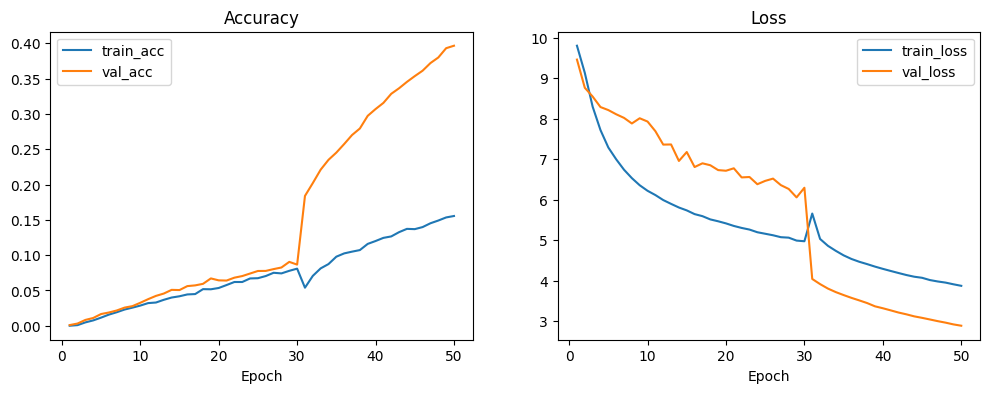

In [46]:
# Load best checkpoint's weights
model.load_weights(CKPT_DIR)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

# Training curves
epochs = range(1, len(combined_history.history['loss']) + 1)
plt.figure(figsize=(12, 4))

# Accuracy - frozen base model
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history.history['accuracy'],    label='train_acc')
plt.plot(epochs, combined_history.history['val_accuracy'],label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history.history['loss'],    label='train_loss')
plt.plot(epochs, combined_history.history['val_loss'],label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

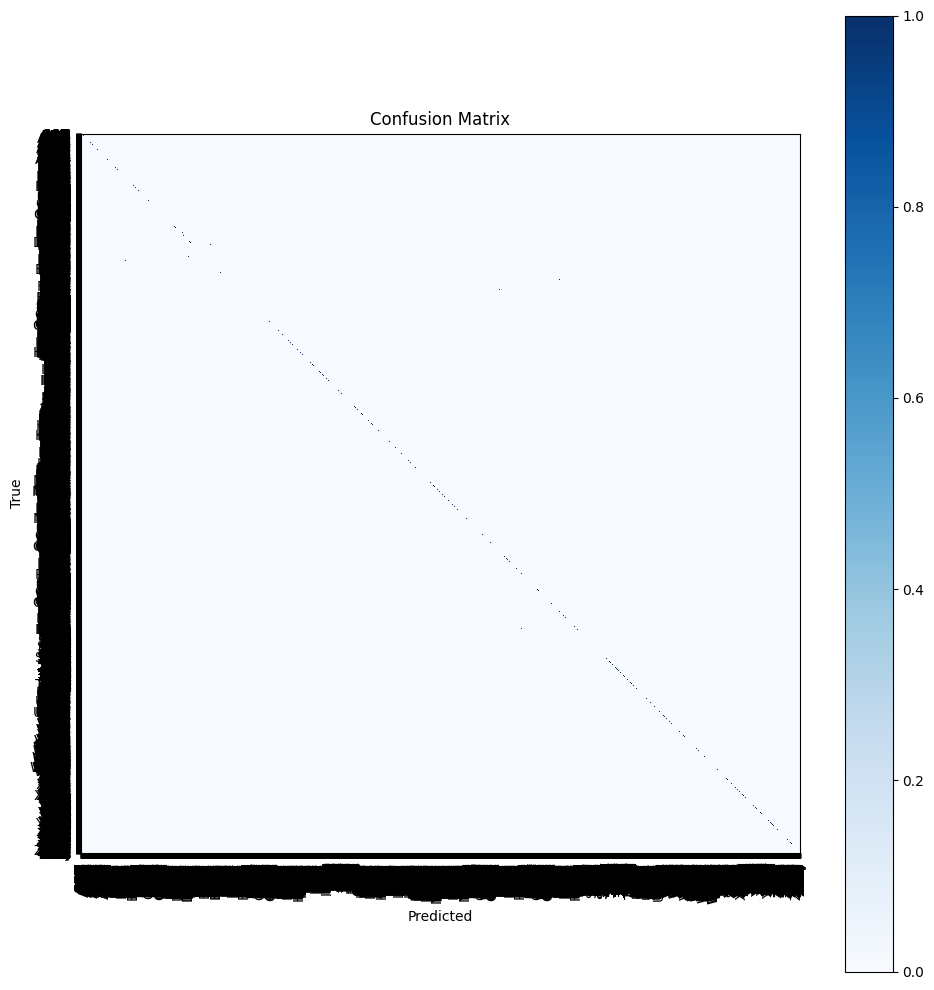

In [47]:
# Gather all ground-truths and predictions
y_true = []
y_pred = []
for batch_x, batch_y in test_ds:
  preds = model.predict(batch_x)
  y_pred.extend(np.argmax(preds, axis=1))
  y_true.extend(np.argmax(batch_y.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# **11. Display Misclassified Examples**

In [ ]:
mis_idx = np.where(all_pred != all_true_idx)[0]
K = 6
plt.figure(figsize=(12, 2*K))
for i, idx in enumerate(mis_idx[:K]):
    img = all_images[idx].squeeze()                           # (H, W)
    true_label = class_names[all_true_idx[idx]]
    pred_label = class_names[all_pred[idx]]

    ax = plt.subplot(K, 1, i+1)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"True: {true_label}    Pred: {pred_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()